In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import numpy as np
import torchvision
from tqdm import tqdm
import torch
from utils import *
import random
import math
from torch.utils.data import Dataset
import torchshow as ts
from networks import *

from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

torch.cuda.set_device(2)
device = "cuda"

In [7]:
img_size = 256
set_seeds(0)

train_path = '/home/data/imagenet/val'
train_transform = transforms.Compose([
			transforms.Resize((img_size,img_size), antialias=True),
			transforms.ToTensor(),
		])
trainset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
imagenet_val_edit = ImageEditDataset(trainset, "/home/public_html/diffusion/image_edit_dataset/imagenet_val_edit.json")
train_subset = torch.utils.data.Subset(imagenet_val_edit, [i for i in range(2000)])
dataloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)

encoder = ConvNextU()
decoder = WMDecoder()
replace_batchnorm(decoder)

Random seed set as 0


In [8]:
inference_steps = 50

checkpoint = torch.load("./checkpoints/ruby-sky-75_models.pth", map_location=device)
encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])

<All keys matched successfully>

In [9]:
siamese = SiameseNetwork(transforms=True)
siamese.load_state_dict(torch.load("./checkpoints/siamese_resnet50_withaug.pth"))
siamese.eval()
siamese = siamese.to(device)

In [10]:
num_of_splits = 4
shuffle_indices = random.sample(range(num_of_splits**2), num_of_splits**2)
shuffler = ImageShuffler(splits=num_of_splits, shuffle_indices=shuffle_indices)

## SDEdit

In [11]:
from diffusers import StableDiffusionImg2ImgPipeline
model_id_or_path = "lambdalabs/miniSD-diffusers"
sdedit = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16, requires_safety_checker = False)
sdedit.safety_checker = None
sdedit.feature_extractor = None
sdedit.scheduler = DPMSolverMultistepScheduler.from_config(sdedit.scheduler.config)
sdedit.set_progress_bar_config(disable=True)
sdedit = sdedit.to(device)

safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [35]:
ex_values, dex_values, dx_values, x_values = [], [], [], []
encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.eval()
decoder.eval()
with torch.no_grad():
    for iters, (img, instruct) in enumerate(dataloader):
        x = img.to(device)
        # Change image into watermakr version
        ex = shuffler.unshuffle(encoder(shuffler.shuffle(x, update_shuffle_indices=True)))
        
        #Diffusion model
        batch_size = x.shape[0]
        dex_pil = sdedit(prompt=list(instruct[2]), image=ex.cpu(), strength=0.3, guidance_scale=10.5, num_inference_steps = inference_steps).images
        dex_list = [transforms.ToTensor()(image) for image in dex_pil]
        dex = torch.stack(dex_list)
        
        dx_pil = sdedit(prompt=list(instruct[2]), image=x.cpu(), strength=0.3, guidance_scale=10.5, num_inference_steps = inference_steps).images
        dx_list = [transforms.ToTensor()(image) for image in dx_pil]
        dx = torch.stack(dx_list)
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(ex, dex.cuda())
        hav_index = torch.where((hav_scores > 0.3) & (hav_scores < 0.5))[0].cpu().numpy()
        
        # Decoder step
        x_value = decoder(shuffler.shuffle(x)[hav_index])
        dx_value = decoder(shuffler.shuffle(dx)[hav_index].to(device))
        ex_value = decoder(shuffler.shuffle(ex)[hav_index])
        dex_value = decoder(shuffler.shuffle(dex)[hav_index].to(device))
        
        
        ex_values.append(ex_value)
        dex_values.append(dex_value)
        dx_values.append(dx_value)
        x_values.append(x_value)
        print("Finish Batch" + str(iters))


Finish Batch0
Finish Batch1
Finish Batch2
Finish Batch3
Finish Batch4
Finish Batch5
Finish Batch6
Finish Batch7
Finish Batch8
Finish Batch9
Finish Batch10
Finish Batch11
Finish Batch12
Finish Batch13
Finish Batch14
Finish Batch15
Finish Batch16
Finish Batch17
Finish Batch18
Finish Batch19
Finish Batch20
Finish Batch21
Finish Batch22
Finish Batch23
Finish Batch24
Finish Batch25
Finish Batch26
Finish Batch27
Finish Batch28
Finish Batch29
Finish Batch30
Finish Batch31
Finish Batch32
Finish Batch33
Finish Batch34
Finish Batch35
Finish Batch36
Finish Batch37
Finish Batch38
Finish Batch39
Finish Batch40
Finish Batch41
Finish Batch42
Finish Batch43
Finish Batch44
Finish Batch45
Finish Batch46
Finish Batch47
Finish Batch48
Finish Batch49
Finish Batch50
Finish Batch51
Finish Batch52
Finish Batch53
Finish Batch54
Finish Batch55
Finish Batch56
Finish Batch57
Finish Batch58
Finish Batch59
Finish Batch60
Finish Batch61
Finish Batch62


TPR @ 1% FPR : 0.914
Corresponding Threshold: 0.5706182747885872
AUC: 0.9899


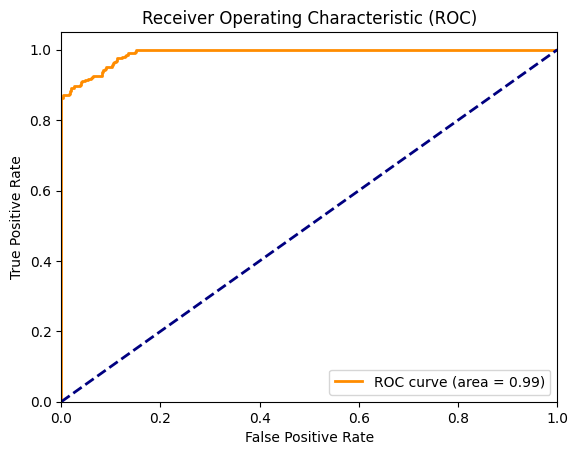

In [30]:
eval_res(ex_values, dex_values, dx_values, x_values)

# Instruc pix2pix

In [ ]:
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
instrucpix2pix = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
instrucpix2pix.to("cuda")
instrucpix2pix.set_progress_bar_config(disable=True)
instrucpix2pix.scheduler = EulerAncestralDiscreteScheduler.from_config(instrucpix2pix.scheduler.config)

In [40]:
resize512 = transforms.Compose([
            transforms.Resize((512,512), antialias=True)
        ])

resizeimg_size = transforms.Compose([
            transforms.Resize((img_size,img_size), antialias=True),
            transforms.ToTensor(),
        ])

In [36]:
ex_values, dex_values, dx_values, x_values = [], [], [], []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for iters, (img, instruct) in enumerate(dataloader):
        x = img.to(device)
        # Change image into watermakr version
        ex = shuffler.unshuffle(encoder(shuffler.shuffle(x, update_shuffle_indices=True)))
        
        #Diffusion model
        batch_size = x.shape[0]
        
        dex_pil = instrucpix2pix(list(instruct[1]), image=resize512(ex).cpu(), num_inference_steps=50, image_guidance_scale=1.8).images
        dex_list = [resizeimg_size(image) for image in dex_pil]
        dex = torch.stack(dex_list)
        
        dx_pil = instrucpix2pix(list(instruct[1]), image=resize512(x).cpu(), num_inference_steps=50, image_guidance_scale=1.8).images
        dx_list = [resizeimg_size(image) for image in dx_pil]
        dx = torch.stack(dx_list)
            
        # HAV between 0.3 and 0.5
        hav_scores = siamese(ex, dex.cuda())
        hav_index = torch.where((hav_scores > 0.3) & (hav_scores < 0.5))[0].cpu().numpy()
        
        
        # Decoder step
        x_value = decoder(shuffler.shuffle(x)[hav_index])
        dx_value = decoder(shuffler.shuffle(dx)[hav_index].to(device))
        ex_value = decoder(shuffler.shuffle(ex)[hav_index])
        dex_value = decoder(shuffler.shuffle(dex)[hav_index].to(device))
        
        ex_values.append(ex_value)
        dex_values.append(dex_value)
        dx_values.append(dx_value)
        x_values.append(x_value)
        print("Finish Batch" + str(iters))


Finish Batch0
Finish Batch1
Finish Batch2
Finish Batch3
Finish Batch4
Finish Batch5
Finish Batch6
Finish Batch7
Finish Batch8
Finish Batch9
Finish Batch10
Finish Batch11
Finish Batch12
Finish Batch13
Finish Batch14
Finish Batch15
Finish Batch16
Finish Batch17
Finish Batch18
Finish Batch19
Finish Batch20
Finish Batch21
Finish Batch22
Finish Batch23
Finish Batch24
Finish Batch25
Finish Batch26
Finish Batch27
Finish Batch28
Finish Batch29
Finish Batch30
Finish Batch31
Finish Batch32
Finish Batch33
Finish Batch34
Finish Batch35
Finish Batch36
Finish Batch37
Finish Batch38
Finish Batch39
Finish Batch40
Finish Batch41
Finish Batch42
Finish Batch43
Finish Batch44
Finish Batch45
Finish Batch46
Finish Batch47
Finish Batch48
Finish Batch49
Finish Batch50
Finish Batch51
Finish Batch52
Finish Batch53
Finish Batch54
Finish Batch55
Finish Batch56
Finish Batch57
Finish Batch58
Finish Batch59
Finish Batch60
Finish Batch61
Finish Batch62


TPR @ 1% FPR : 0.948
Corresponding Threshold: 0.5090683278040152
AUC: 0.9928600000000001


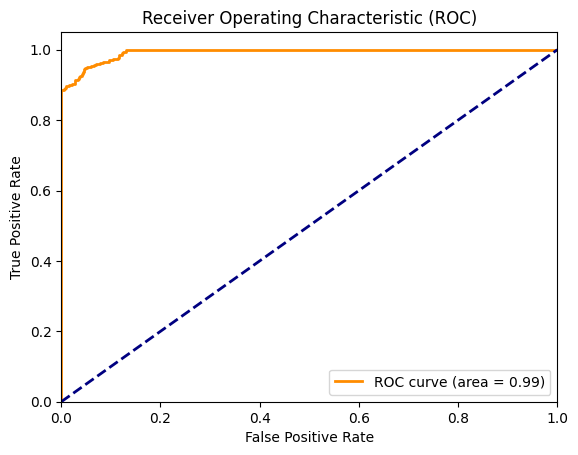

In [28]:
eval_res(ex_values, dex_values, dx_values, x_values)

## Inpainting

In [ ]:
imginpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, safety_checker=None
)
imginpaint.set_progress_bar_config(disable=True)
imginpaint.safety_checker = lambda images, clip_input: (images, None)
imginpaint = imginpaint.to("cuda")

In [18]:
resize512 = transforms.Compose([
            transforms.Resize((512,512), antialias=True)
        ])

resizeimg_size = transforms.Compose([
            transforms.Resize((img_size,img_size), antialias=True),
            transforms.ToTensor(),
        ])

In [37]:
ex_values, dex_values, dx_values, x_values = [], [], [], []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for iters, (img, instruct) in enumerate(dataloader):
        x = img.to(device)
        # Change image into watermakr version
        ex = encoder(shuffler.split_and_recombine(x, update_shuffle_indices=True))
        
        #Diffusion model
        batch_size = x.shape[0]
        mask_batch = torch.stack([transforms.ToTensor()(generate_random_shape_mask()) for _ in range(batch_size)])
        
        dex_pil = imginpaint(prompt=list(instruct[2]), image=resize512(shuffler.unshuffle(ex)).cpu(), mask_image=mask_batch).images
        dex_list = [resizeimg_size(image) for image in dex_pil]
        dex = torch.stack(dex_list)
        
        dx_pil = imginpaint(prompt=list(instruct[2]), image=resize512(x).cpu(), mask_image=mask_batch).images
        dx_list = [resizeimg_size(image) for image in dx_pil]
        dx = torch.stack(dx_list)
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(ex, dex.cuda())
        hav_index = torch.where((hav_scores > 0.3) & (hav_scores < 0.5))[0].cpu().numpy()
        
        # Decoder step
        x_value = decoder(shuffler.shuffle(x)[hav_index])
        dx_value = decoder(shuffler.shuffle(dx)[hav_index].to(device))
        ex_value = decoder(shuffler.shuffle(ex)[hav_index])
        dex_value = decoder(shuffler.shuffle(dex)[hav_index].to(device))
        
        ex_values.append(ex_value)
        dex_values.append(dex_value)
        dx_values.append(dx_value)
        x_values.append(x_value)
        print("Finish Batch" + str(iters))


Finish Batch0
Finish Batch1
Finish Batch2
Finish Batch3
Finish Batch4
Finish Batch5
Finish Batch6
Finish Batch7
Finish Batch8
Finish Batch9
Finish Batch10
Finish Batch11
Finish Batch12
Finish Batch13
Finish Batch14
Finish Batch15
Finish Batch16
Finish Batch17
Finish Batch18
Finish Batch19
Finish Batch20
Finish Batch21
Finish Batch22
Finish Batch23
Finish Batch24
Finish Batch25
Finish Batch26
Finish Batch27
Finish Batch28
Finish Batch29
Finish Batch30
Finish Batch31
Finish Batch32
Finish Batch33
Finish Batch34
Finish Batch35
Finish Batch36
Finish Batch37
Finish Batch38
Finish Batch39
Finish Batch40
Finish Batch41
Finish Batch42
Finish Batch43
Finish Batch44
Finish Batch45
Finish Batch46
Finish Batch47
Finish Batch48
Finish Batch49
Finish Batch50
Finish Batch51
Finish Batch52
Finish Batch53
Finish Batch54
Finish Batch55
Finish Batch56
Finish Batch57
Finish Batch58
Finish Batch59
Finish Batch60
Finish Batch61
Finish Batch62


TPR @ 1% FPR : 0.856
Corresponding Threshold: 0.6554318337049378
AUC: 0.9749


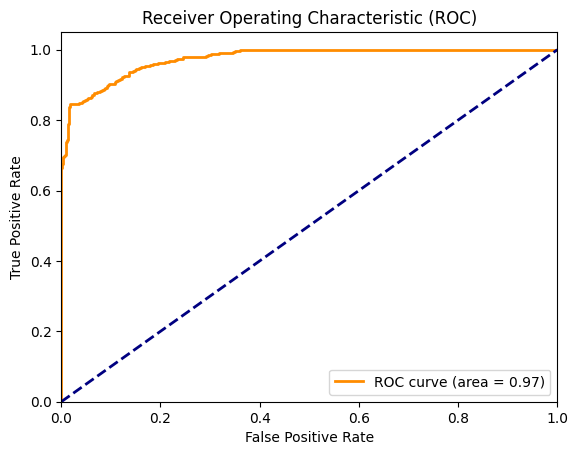

In [25]:
eval_res(ex_values, dex_values, dx_values, x_values)

## Zero 1-to-3

In [4]:
import diffusers  # 0.12.1
import math
import numpy as np
import sys
import time
import torch
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from functools import partial
from ldm.models.diffusion.ddim import DDIMSampler
from PIL import Image
from transformers import AutoFeatureExtractor
from torch import autocast
from torchvision import transforms

In [ ]:
models = dict()
models['turncam'] = load_model_from_config('./checkpoints/105000.ckpt', device=device)

In [38]:
ex_values, dex_values, dx_values, x_values = [], [], [], []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for iters, (img, instruct) in enumerate(dataloader):
        x = img.to(device)
        # Change image into watermakr version
        ex = encoder(shuffler.split_and_recombine(x, update_shuffle_indices=True))
        
        #Diffusion model
        batch_size = img.shape[0]
        dex_pil = [zero123(shuffler.unshuffle(ex).cpu()[i], models, [random.randint(0,10), random.randint(0,10), 0]) for i in range(batch_size)]
        dex_list = [transforms.ToTensor()(image) for image in dex_pil]
        dex = torch.stack(dex_list)
        
        dx_pil = [zero123(x.cpu()[i], models, [random.randint(0,10), random.randint(0,10), 0]) for i in range(batch_size)]
        dx_list = [transforms.ToTensor()(image) for image in dx_pil]
        dx = torch.stack(dx_list)
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(noise, diff_img.cuda())
        hav_index = torch.where((hav > 0.3) & (hav < 0.5))[0].cpu().numpy()
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(ex, dex.cuda())
        hav_index = torch.where((hav_scores > 0.3) & (hav_scores < 0.5))[0].cpu().numpy()
        
        # Decoder step
        x_value = decoder(shuffler.shuffle(x)[hav_index])
        dx_value = decoder(shuffler.shuffle(dx)[hav_index].to(device))
        ex_value = decoder(shuffler.shuffle(ex)[hav_index])
        dex_value = decoder(shuffler.shuffle(dex)[hav_index].to(device))
        
        ex_values.append(ex_value)
        dex_values.append(dex_value)
        dx_values.append(dx_value)
        x_values.append(x_value)
        print("Finish Batch" + str(iters))

Finish Batch0
Finish Batch1
Finish Batch2
Finish Batch3
Finish Batch4
Finish Batch5
Finish Batch6
Finish Batch7
Finish Batch8
Finish Batch9
Finish Batch10
Finish Batch11
Finish Batch12
Finish Batch13
Finish Batch14
Finish Batch15
Finish Batch16
Finish Batch17
Finish Batch18
Finish Batch19
Finish Batch20
Finish Batch21
Finish Batch22
Finish Batch23
Finish Batch24
Finish Batch25
Finish Batch26
Finish Batch27
Finish Batch28
Finish Batch29
Finish Batch30
Finish Batch31
Finish Batch32
Finish Batch33
Finish Batch34
Finish Batch35
Finish Batch36
Finish Batch37
Finish Batch38
Finish Batch39
Finish Batch40
Finish Batch41
Finish Batch42
Finish Batch43
Finish Batch44
Finish Batch45
Finish Batch46
Finish Batch47
Finish Batch48
Finish Batch49
Finish Batch50
Finish Batch51
Finish Batch52
Finish Batch53
Finish Batch54
Finish Batch55
Finish Batch56
Finish Batch57
Finish Batch58
Finish Batch59
Finish Batch60
Finish Batch61
Finish Batch62


AUC: 0.9809
TPR @ 1% FPR : 0.866
Corresponding Threshold: 0.6489130338327916
AUC: 0.9809


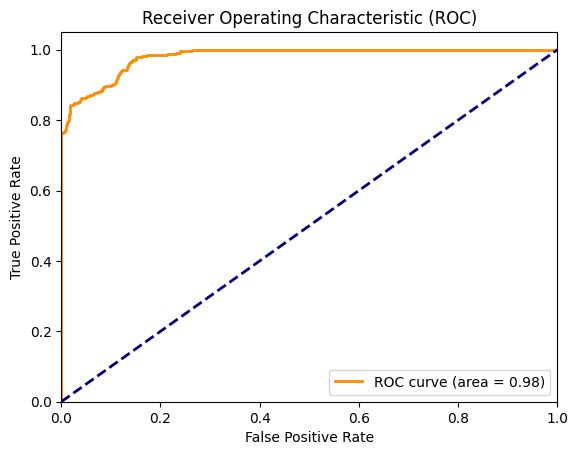

In [21]:
eval_res(ex_values, dex_values, dx_values, x_values)

# DALLE 2

In [ ]:
dalle2 = ImageGenerator(api_key = "Input your openai api key!")

In [39]:
ex_values, dex_values, dx_values, x_values = [], [], [], []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for iters, (img, instruct) in enumerate(dataloader):
        x = img.to(device)
        # Change image into watermakr version
        ex = encoder(shuffler.split_and_recombine(x, update_shuffle_indices=True))
        
        #Diffusion model
        batch_size = x.shape[0]
        dex = dalle2.imageVariations(shuffler.unshuffle(ex.clone()))
        dx = dalle2.imageVariations(x.clone())
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(noise, diff_img.cuda())
        hav_index = torch.where((hav > 0.3) & (hav < 0.5))[0].cpu().numpy()
        
        # HAV between 0.3 and 0.5
        hav_scores = siamese(ex, dex.cuda())
        hav_index = torch.where((hav_scores > 0.3) & (hav_scores < 0.5))[0].cpu().numpy()
        
        # Decoder step
        x_value = decoder(shuffler.shuffle(x)[hav_index])
        dx_value = decoder(shuffler.shuffle(dx)[hav_index].to(device))
        ex_value = decoder(shuffler.shuffle(ex)[hav_index])
        dex_value = decoder(shuffler.shuffle(dex)[hav_index].to(device))
        
        ex_values.append(ex_value)
        dex_values.append(dex_value)
        dx_values.append(dx_value)
        x_values.append(x_value)
        print("Finish Batch" + str(iters))

Finish Batch0
Finish Batch1
Finish Batch2
Finish Batch3
Finish Batch4
Finish Batch5
Finish Batch6
Finish Batch7
Finish Batch8
Finish Batch9
Finish Batch10
Finish Batch11
Finish Batch12
Finish Batch13
Finish Batch14
Finish Batch15
Finish Batch16
Finish Batch17
Finish Batch18
Finish Batch19
Finish Batch20
Finish Batch21
Finish Batch22
Finish Batch23
Finish Batch24
Finish Batch25
Finish Batch26
Finish Batch27
Finish Batch28
Finish Batch29
Finish Batch30
Finish Batch31
Finish Batch32
Finish Batch33
Finish Batch34
Finish Batch35
Finish Batch36
Finish Batch37
Finish Batch38
Finish Batch39
Finish Batch40
Finish Batch41
Finish Batch42
Finish Batch43
Finish Batch44
Finish Batch45
Finish Batch46
Finish Batch47
Finish Batch48
Finish Batch49
Finish Batch50
Finish Batch51
Finish Batch52
Finish Batch53
Finish Batch54
Finish Batch55
Finish Batch56
Finish Batch57
Finish Batch58
Finish Batch59
Finish Batch60
Finish Batch61
Finish Batch62


AUC: 0.9339000000000001
TPR @ 1% FPR : 0.692
Corresponding Threshold: 0.6934096265858802
AUC: 0.9339000000000001


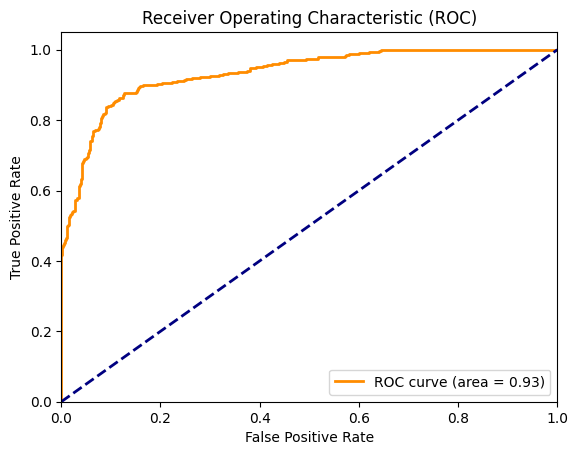

In [20]:
eval_res(ex_values, dex_values, dx_values, x_values)